# CBP transmission

The goal of this notebook is to comput the CBP transmission curve.

In [1]:
import os, sys
print(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
from astropy import constants as const
from astropy import units as u
from scipy.interpolate import interp1d

from solarcell_dataset import SolarCellDataSet, SolarCellRun, calculate_npulses, get_info_from_filename
%matplotlib notebook

/home/jneveu/stardice/analysis/cbp_paper


Solar cell data run :

In [9]:
data_dir = "/data/STARDICE/cbp/solarcell/ut20211012/box_on_fits"
other_str = ""
nbursts = 5

run = SolarCellRun(directory_path=data_dir, tag=other_str, nbursts=nbursts)
run.load_from_file(os.path.join(data_dir, f"QSWMax_withAmpBox_restartOctober_test4.npy"))
nt = run.data

data_dir = "/data/STARDICE/cbp/solarcell/ut20210719"
other_str = "Angle_0"

run2 = SolarCellRun(directory_path=data_dir, tag=other_str, nbursts=nbursts)
run2.load_from_file(os.path.join(data_dir, f"QSWMax_EMPTY_Angle_0_ntuple.npy"))
nt = run2.data

run3 = SolarCellRun(directory_path=data_dir, tag=other_str, nbursts=nbursts)
run3.load_from_file(os.path.join(data_dir, f"QSWMax_EMPTY_Angle_0_ntuple_old20210725.npy"))
nt3 = run2.data

Solar cell and photodiode quantum efficiencies :

<IPython.core.display.Javascript object>


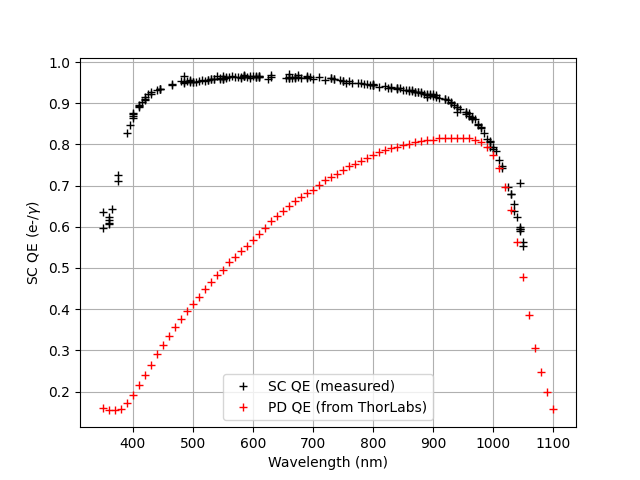

In [10]:
ref_data_root = "/data/STARDICE/cbp/solarcell/refCalData/"
SC_QE_data_file = ref_data_root + 'SC_QE_from_mono_SC_ED_20210618_MultiDay.txt'
PD_QE_data_file = ref_data_root + 'SM05PD1B_QE.csv'

SC_QE = np.loadtxt(SC_QE_data_file, skiprows=1, delimiter=",").T
PD_QE = np.loadtxt(PD_QE_data_file, skiprows=1, delimiter=",").T

# PD_QE is in A/W units, convert it to e-/photons as SC_QE
PD_QE[1] *= (const.h * const.c / (PD_QE[0] * 1e-9 * u.meter * const.e.value)).value

SC_QE_f = interp1d(SC_QE[0], SC_QE[1], bounds_error=False, fill_value=np.min(SC_QE[1]))
PD_QE_f = interp1d(PD_QE[0], PD_QE[1], bounds_error=False, fill_value=np.min(PD_QE[1]))

#Make plots of the background data that we used in our measurements
fig = plt.figure()
SC_QE_plot = plt.plot(SC_QE[0], SC_QE[1], 'k+', label='SC QE (measured)')
PD_QE_plot = plt.plot(PD_QE[0], PD_QE[1], 'r+', label='PD QE (from ThorLabs)')
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'SC QE (e-/$\gamma$)')
plt.grid()
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


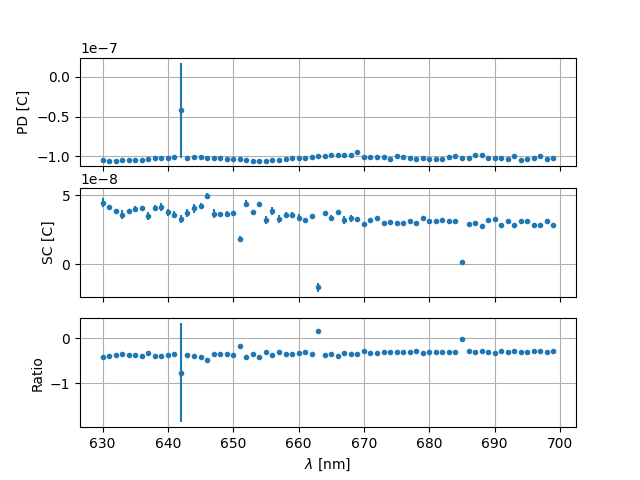

In [11]:
run.plot_summary()

CBP transmission :

<IPython.core.display.Javascript object>


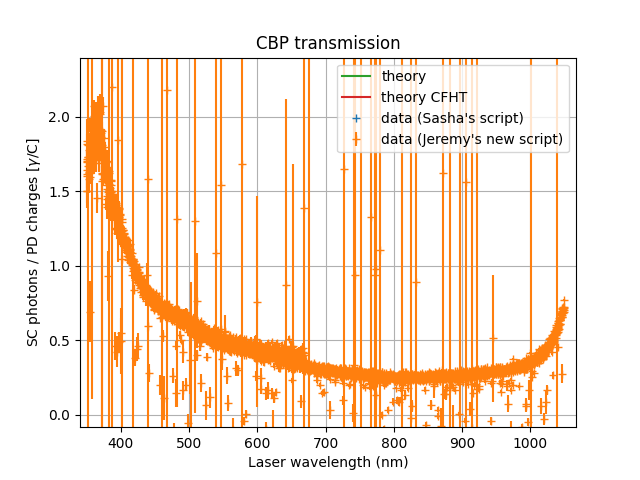

In [7]:
csv = np.loadtxt(os.path.join(data_dir, "QSWMax_EMPTY_Angle0SC_photons_over_PD_electrons.txt"), skiprows=1, delimiter=",")

wl, tr, tr_err = run.get_SC_photons_over_PD_charges(plot=False)

double_Al_wavelength, double_Al_responsivity = np.loadtxt(os.path.join(ref_data_root, 'TwoBounceAl.dat'), delimiter=',', skiprows=1).T
Al_wl, Al_CFHT = np.loadtxt(os.path.join(ref_data_root, 'CFHT_Primary_Transmission.dat'), delimiter=' ', skiprows=0).T
Al_wl *= 0.1
Al_CFHT *= Al_CFHT

fig = plt.figure()
plt.errorbar(csv.T[0], csv.T[1], marker='+', linestyle="none", label="data (Sasha's script)")
plt.errorbar(run.data["set_wl"], tr, yerr=tr_err, marker='+', linestyle="none", label="data (Jeremy's new script)")
plt.plot(double_Al_wavelength, 6*double_Al_responsivity / PD_QE_f(double_Al_wavelength), '-', label="theory")
plt.plot(Al_wl, 6*Al_CFHT / PD_QE_f(Al_wl), '-', label="theory CFHT")
plt.xlabel('Laser wavelength (nm)')
plt.ylabel('SC photons / PD charges [$\gamma$/C]')
plt.grid()
plt.title("CBP transmission")
plt.legend()
plt.show()



Photon ratio :

In [6]:
np.save("cbp_transmission.npy", [run.data["set_wl"], tr, tr_err])

/home/jneveu/stardice/analysis/cbp_paper/solarcell_dataset.py:884: RuntimeWarning: invalid value encountered in true_divide
  tr_err = tr * np.sqrt((self.data["sc_charge_total_err"] / self.data["sc_charge_total"]) ** 2 + (


<IPython.core.display.Javascript object>


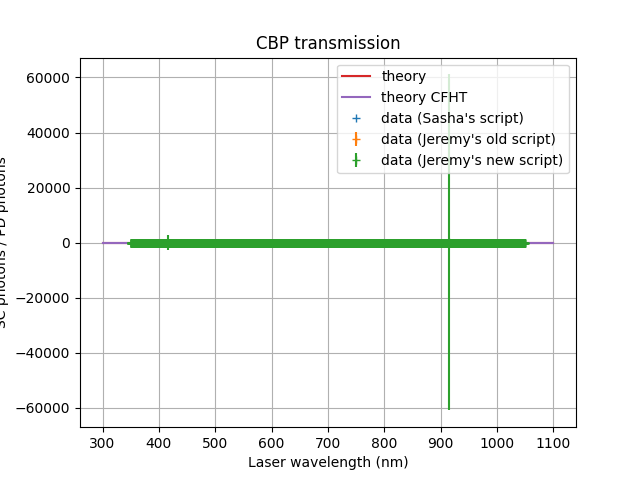

In [7]:
csv = np.loadtxt(os.path.join(data_dir, "QSWMax_EMPTY_Angle0SC_photons_over_PD_photons.txt"), skiprows=1, delimiter=",")

wl, tr, tr_err = run.get_SC_photons_over_PD_photons(plot=False)
wl, tr2, tr2_err = run2.get_SC_photons_over_PD_photons(plot=False)

fig = plt.figure()
plt.errorbar(csv.T[0], csv.T[1], marker='+', linestyle="none", label="data (Sasha's script)")
plt.errorbar(run2.data["set_wl"], tr2, yerr=tr2_err, marker='+', linestyle="none", label="data (Jeremy's old script)")
plt.errorbar(run.data["set_wl"], tr, yerr=tr_err, marker='+', linestyle="none", label="data (Jeremy's new script)")
plt.plot(double_Al_wavelength, 6*double_Al_responsivity, '-', label="theory")
plt.plot(Al_wl, 6*Al_CFHT, '-', label="theory CFHT")
plt.xlabel('Laser wavelength (nm)')
plt.ylabel('SC photons / PD photons')
plt.title("CBP transmission")
plt.grid()
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


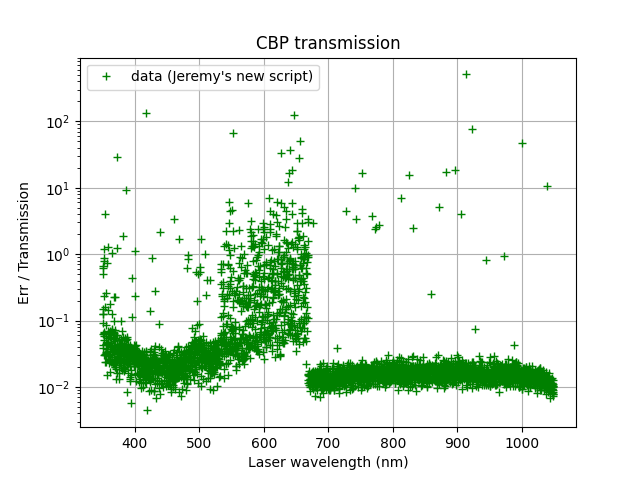

In [8]:
fig = plt.figure()
plt.plot(run.data["set_wl"], tr_err/tr, color="g", marker='+', linestyle="none", label="data (Jeremy's new script)")
plt.title("CBP transmission")
plt.grid()
plt.yscale("log")
plt.xlabel('Laser wavelength (nm)')
plt.ylabel('Err / Transmission')
plt.legend()
plt.show()


<IPython.core.display.Javascript object>


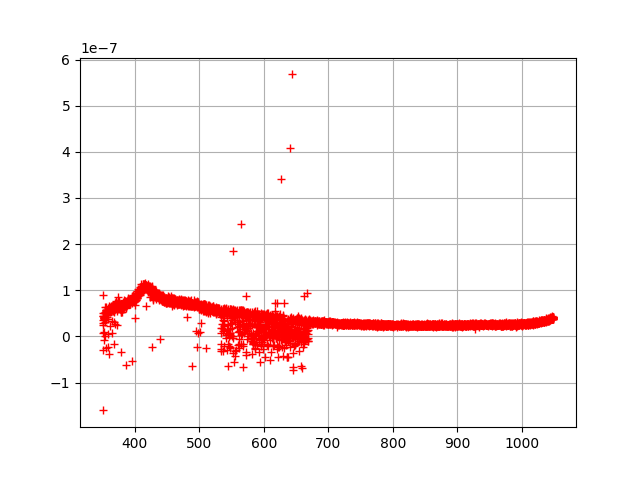

In [9]:
fig = plt.figure()
plt.plot(run.data["set_wl"], run.data["sc_charge_total"], 'r+')
plt.grid()
plt.show()

/home/jneveu/stardice/analysis/cbp_paper/solarcell_dataset.py:884: RuntimeWarning: invalid value encountered in true_divide
  tr_err = tr * np.sqrt((self.data["sc_charge_total_err"] / self.data["sc_charge_total"]) ** 2 + (


<IPython.core.display.Javascript object>


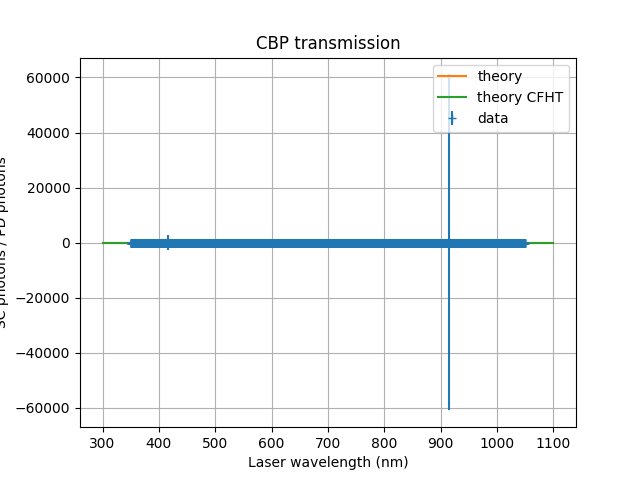

In [10]:
_ = run.get_SC_photons_over_PD_photons(plot=True)

In [11]:
run.data

array([('EMPTY', 'Max', 5, 1000,  350., -4.85919470e-08, 1.16094414e-10, 5.13246191e-08, 1.94949376e-09, -6.02683532e-12,  3.07499988e-12,  1.68634087e-09, -7.51697176e-10),
       ('EMPTY', 'Max', 5, 1000,  351., -4.49346488e-08, 1.55130633e-10, 2.47786710e-08, 3.75343278e-09,  5.16940117e-12, -4.22991828e-13,  3.25518153e-09,  9.38867703e-10),
       ('EMPTY', 'Max', 5, 1000,  352., -4.53341967e-08, 3.50708415e-11, 4.04513372e-08, 2.58427537e-09,  5.91738895e-12, -1.07836283e-12,  2.63660352e-10,  1.68397840e-09),
       ...,
       ('EMPTY', 'Max', 5,   52, 1047., -9.53550313e-08, 5.72464282e-11, 3.82105065e-08, 4.37569227e-10, -7.80170751e-12,  6.25842033e-12, -5.32630442e-09, -6.13520942e-09),
       ('EMPTY', 'Max', 5,   53, 1048., -9.48444177e-08, 3.18313949e-12, 3.86458706e-08, 2.99480362e-10,  1.67530100e-12,  1.53578972e-12, -3.51559456e-09, -5.44720918e-09),
       ('EMPTY', 'Max', 5,   55, 1049., -9.59808906e-08, 3.03210254e-11, 4.17917040e-08, 3.71096288e-10, -2.65191088e-

<IPython.core.display.Javascript object>


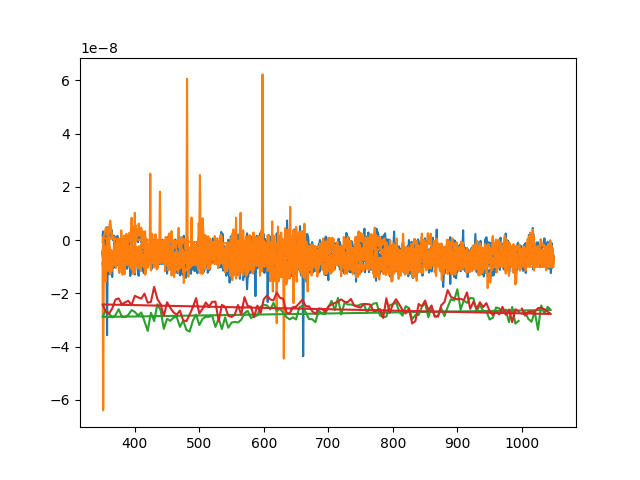

In [12]:
fig=plt.figure()
plt.plot(run.data['set_wl'], run.data['sc_ik1'])
plt.plot(run.data['set_wl'], run.data['sc_ik2'])
plt.plot(run2.data['set_wl'], run2.data['sc_ik1'])
plt.plot(run2.data['set_wl'], run2.data['sc_ik2'])
plt.show()

In [13]:
np.std(run.data['sc_ik2'])

4.320154771195142e-09

In [14]:
np.std(run2.data['sc_ik2'])

2.606500149073204e-09

In [15]:
from scipy.stats import median_absolute_deviation

In [16]:
median_absolute_deviation(run2.data['sc_ik2'])

/home/jneveu/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  """Entry point for launching an IPython kernel.


2.7683297072363464e-09

In [17]:
run.data

array([('EMPTY', 'Max', 5, 1000,  350., -4.85919470e-08, 1.16094414e-10, 5.13246191e-08, 1.94949376e-09, -6.02683532e-12,  3.07499988e-12,  1.68634087e-09, -7.51697176e-10),
       ('EMPTY', 'Max', 5, 1000,  351., -4.49346488e-08, 1.55130633e-10, 2.47786710e-08, 3.75343278e-09,  5.16940117e-12, -4.22991828e-13,  3.25518153e-09,  9.38867703e-10),
       ('EMPTY', 'Max', 5, 1000,  352., -4.53341967e-08, 3.50708415e-11, 4.04513372e-08, 2.58427537e-09,  5.91738895e-12, -1.07836283e-12,  2.63660352e-10,  1.68397840e-09),
       ...,
       ('EMPTY', 'Max', 5,   52, 1047., -9.53550313e-08, 5.72464282e-11, 3.82105065e-08, 4.37569227e-10, -7.80170751e-12,  6.25842033e-12, -5.32630442e-09, -6.13520942e-09),
       ('EMPTY', 'Max', 5,   53, 1048., -9.48444177e-08, 3.18313949e-12, 3.86458706e-08, 2.99480362e-10,  1.67530100e-12,  1.53578972e-12, -3.51559456e-09, -5.44720918e-09),
       ('EMPTY', 'Max', 5,   55, 1049., -9.59808906e-08, 3.03210254e-11, 4.17917040e-08, 3.71096288e-10, -2.65191088e-

In [18]:
print("Dark currents:")
print("today:", np.median(run.data['sc_ik2']), "A")
print("July:", np.median(run2.data['sc_ik2']), "A")
print("ratio:", np.median(run.data['sc_ik2'])/np.median(run2.data['sc_ik2']))

Dark currents:
today: -6.034895128841678e-09 A
July: -2.4973304030352227e-08 A
ratio: 0.24165385251014226


In [19]:
print("Loss of light switching the holes:")
print("ratio:", np.mean(run.data["sc_charge_total"])/np.mean(run2.data["sc_charge_total"]))
print("ratio:", np.mean(run.data["pd_charge_total"])/np.mean(run2.data["pd_charge_total"]))

Loss of light switching the holes:
ratio: 0.05509185962239675
ratio: 1.233405392636127
